
---

# **🔍 04 - Model Testing: Traditional NLP Pipeline**

## **📑 Table of Contents**
1.  [🎯 Objectives](#-objectives)
2.  [⚙️ Setup & Imports](#-setup--imports)
3.  [📥 Load Aggressively Cleaned Data](#-load-aggressively-cleaned-data)
4.  [🌿 Text Processing: Stemming vs Lemmatization](#-text-processing-stemming-vs-lemmatization)
5.  [📊 TF-IDF Vectorization](#-tf-idf-vectorization)
6.  [🤖 Model Training](#-model-training)
7.  [📊 Comprehensive Model Evaluation](#-comprehensive-model-evaluation)
8.  [📈 Advanced Visualizations](#-advanced-visualizations)
9.  [🏆 Best Model Selection](#-best-model-selection)
10. [💾 Save Results](#-save-results)

---

## **🎯 Objectives**
- Compare stemming vs lemmatization techniques
- Test traditional NLP pipeline with TF-IDF
- Evaluate multiple classification models
- Select the best text processing strategy



---

## **⚙️ 1. Setup & Imports**


In [ ]:

# Add project root to path
import sys
import os
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

# Model training
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Enhanced evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, roc_curve, confusion_matrix, classification_report,
                            precision_recall_curve, auc)

# NLP libraries
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Model persistence
import joblib

from src.experiment_tracker import log_experiment

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

print("✅ All libraries imported successfully!")
%matplotlib inline
plt.style.use('default')


✅ All libraries imported successfully!


[nltk_data] Downloading package punkt to /Users/guillermo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/guillermo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guillermo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



---

## **📥 2. Load Aggressively Cleaned Data**


In [2]:

print("📁 Loading cleaned data...")
# 🔧 IMPROVEMENT 1: Use ORIGINAL cleaning (not aggressive) for better generalization
df_original = pd.read_csv('../dataset/01_interim/cleaned_data.csv')
df_basic = pd.read_csv('../dataset/01_interim/cleaned_data_basic.csv')

print(f"📊 Dataset shape: {df_original.shape}")
print(f"🎯 Label distribution:\n{df_original['label'].value_counts()}")

# 🔧 IMPROVEMENT 2: Use BOTH title AND text (not just title)
def combine_text_features(df, strategy='title_text'):
    """Combine title and text features"""
    if strategy == 'title_only':
        return df['clean_title'].fillna('')
    elif strategy == 'text_only':
        return df['clean_text'].fillna('')
    else:  # title_text (recommended)
        title = df['clean_title'].fillna('')
        text = df['clean_text'].fillna('')
        return title + ' | ' + text

# Test different feature combinations
feature_strategies = {
    'original_title_text': (df_original, 'title_text'),
    'original_text_only': (df_original, 'text_only'),
    'basic_title_text': (df_basic, 'title_text'),
    'basic_text_only': (df_basic, 'text_only')
}

print("📋 Available feature strategies:")
for strategy in feature_strategies.keys():
    print(f"   - {strategy}")

# Use the best performing combination
selected_df = df_original  # Original cleaning performs better
X = combine_text_features(selected_df, 'title_text')
y = selected_df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📚 Training set: {len(X_train)} samples")
print(f"🧪 Test set: {len(X_test)} samples")
print(f"📝 Sample combined text: {X.iloc[0][:100]}...")


📁 Loading cleaned data...
📊 Dataset shape: (39942, 8)
🎯 Label distribution:
label
1    19999
0    19943
Name: count, dtype: int64
📋 Available feature strategies:
   - original_title_text
   - original_text_only
   - basic_title_text
   - basic_text_only
📚 Training set: 31953 samples
🧪 Test set: 7989 samples
📝 Sample combined text: budget fight looms republicans flip their fiscal script | washington reuters the head conservative r...



---

## **🌿 3. Text Processing: Stemming vs Lemmatization**


In [3]:

print("🌿 Preparing text processing functions...")

# Initialize processors
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def stem_text(text):
    """Apply stemming to text"""
    words = word_tokenize(str(text))
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join([stemmer.stem(word) for word in words])

def lemmatize_text(text):
    """Apply lemmatization to text"""
    words = word_tokenize(str(text))
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

# Test the functions
test_text = "running runners ran easily easier quickly"
print("🧪 Test Text:", test_text)
print("✂️ Stemmed:", stem_text(test_text))
print("🌿 Lemmatized:", lemmatize_text(test_text))

# Apply processing to datasets
print("\n🔄 Applying text processing strategies...")

processing_strategies = {
    'original': X_train,
    'stemmed': X_train.apply(stem_text),
    'lemmatized': X_train.apply(lemmatize_text)
}

print("✅ Text processing completed!")


🌿 Preparing text processing functions...
🧪 Test Text: running runners ran easily easier quickly
✂️ Stemmed: run runner ran easili easier quickli
🌿 Lemmatized: running runner ran easily easier quickly

🔄 Applying text processing strategies...
✅ Text processing completed!



---

## **📊 4. TF-IDF Vectorization**


In [4]:
print("📊 Applying TF-IDF vectorization...")

# First, ensure we handle any NaN values
print("   Checking for and handling NaN values...")
for strategy, text_data in processing_strategies.items():
    # Check for NaN values
    nan_count = text_data.isnull().sum()
    if nan_count > 0:
        print(f"      Found {nan_count} NaN values in {strategy} strategy - replacing with empty strings")
        processing_strategies[strategy] = text_data.fillna('')

vectorizers = {}
X_processed = {}

for strategy, text_data in processing_strategies.items():
    print(f"   Processing: {strategy}")
    
    # Double-check for any remaining NaN values
    text_data = text_data.fillna('')
    
    # 🔧 IMPROVEMENT 3: Optimized TF-IDF configuration for better performance
    vectorizer = TfidfVectorizer(
        max_features=10000,      # Increased vocabulary for richer features
        stop_words='english',
        ngram_range=(1, 3),      # Include trigrams for better context
        min_df=3,                # Slightly higher threshold for noise reduction
        max_df=0.90,             # Lower threshold to remove very common words
        sublinear_tf=True,       # Apply sublinear tf scaling (1 + log(tf))
        use_idf=True,            # Use inverse document frequency
        smooth_idf=True,         # Smooth idf weights
        dtype=np.float32         # Use float32 to save memory
    )
    
    try:
        X_processed[strategy] = vectorizer.fit_transform(text_data)
        vectorizers[strategy] = vectorizer
        
        print(f"      Vocabulary size: {len(vectorizer.get_feature_names_out())}")
        print(f"      Matrix shape: {X_processed[strategy].shape}")
    except Exception as e:
        print(f"      Error processing {strategy}: {e}")
        # Debug: check what's in the text data that might be causing issues
        print(f"      Sample of text data: {text_data.head(3).tolist()}")

# Also process test data - with NaN handling
X_test_processed = {}
for strategy in processing_strategies.keys():
    if strategy == 'original':
        test_data = X_test.fillna('')  # Handle NaN values
    elif strategy == 'stemmed':
        test_data = X_test.apply(stem_text).fillna('')  # Handle NaN values
    else:
        test_data = X_test.apply(lemmatize_text).fillna('')  # Handle NaN values
    
    try:
        X_test_processed[strategy] = vectorizers[strategy].transform(test_data)
    except Exception as e:
        print(f"Error transforming test data for {strategy}: {e}")

print("✅ TF-IDF vectorization completed!")

📊 Applying TF-IDF vectorization...
   Checking for and handling NaN values...
   Processing: original
      Vocabulary size: 10000
      Matrix shape: (31953, 10000)
   Processing: stemmed
      Vocabulary size: 10000
      Matrix shape: (31953, 10000)
   Processing: lemmatized
      Vocabulary size: 10000
      Matrix shape: (31953, 10000)
✅ TF-IDF vectorization completed!



---

## **🤖 5. Model Training**


In [5]:
print("🤖 Initializing models with improved configurations...")
# 🔧 IMPROVEMENT 4: Better model configurations with proper regularization
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=2000, 
        random_state=42,
        C=1.0,                    # L2 regularization strength
        solver='liblinear'        # Good for small datasets
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,         # More trees for better performance
        max_depth=10,             # Prevent overfitting
        min_samples_split=5,      # Minimum samples to split
        min_samples_leaf=2,       # Minimum samples in leaf
        random_state=42
    ),
    'SVM': SVC(
        kernel='linear', 
        probability=True, 
        random_state=42,
        C=1.0,                    # Regularization parameter (key for generalization)
        class_weight='balanced'   # Handle class imbalance
    ),
    'Naive Bayes': MultinomialNB(
        alpha=1.0                 # Laplace smoothing
    )
}

# Store all results
all_results = {}
all_predictions = {}

print("🚀 Training models across all processing strategies...")
for strategy in processing_strategies.keys():
    print(f"\n📊 Strategy: {strategy.upper()}")
    print("=" * 40)
    
    strategy_results = {}
    strategy_predictions = {}
    
    for name, model in models.items():
        print(f"   Training {name}...")
        
        # Clone model for each strategy
        model_instance = model.__class__(**model.get_params())
        model_instance.fit(X_processed[strategy], y_train)
        
        # Store results
        strategy_results[name] = model_instance
        strategy_predictions[name] = {
            'model': model_instance,
            'X_test': X_test_processed[strategy]
        }
    
    all_results[strategy] = strategy_results
    all_predictions[strategy] = strategy_predictions

print("✅ All models trained successfully!")


🤖 Initializing models with improved configurations...
🚀 Training models across all processing strategies...

📊 Strategy: ORIGINAL
   Training Logistic Regression...
   Training Random Forest...
   Training SVM...
   Training Naive Bayes...

📊 Strategy: STEMMED
   Training Logistic Regression...
   Training Random Forest...
   Training SVM...
   Training Naive Bayes...

📊 Strategy: LEMMATIZED
   Training Logistic Regression...
   Training Random Forest...
   Training SVM...
   Training Naive Bayes...
✅ All models trained successfully!



---

## **📊 6. Comprehensive Model Evaluation**


In [6]:

def comprehensive_evaluation(model, X_test, y_test, model_name="Model"):
    """Perform comprehensive evaluation with multiple metrics"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    else:
        metrics['roc_auc'] = None
    
    return metrics, y_pred, y_pred_proba

print("📊 Evaluating all models comprehensively...")
evaluation_results = {}

for strategy, models_dict in all_predictions.items():
    print(f"\n🔍 Evaluating strategy: {strategy.upper()}")
    print("=" * 50)
    
    strategy_results = {}
    
    for name, data in models_dict.items():
        metrics, y_pred, y_pred_proba = comprehensive_evaluation(
            data['model'], data['X_test'], y_test, name
        )
        
        strategy_results[name] = metrics
        print(f"   {name:20} | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1']:.4f}")
    
    evaluation_results[strategy] = strategy_results

print("✅ Comprehensive evaluation completed!")



📊 Evaluating all models comprehensively...


NameError: name 'all_predictions' is not defined


---

## **📈 7. Advanced Visualizations**


🎨 Generating advanced visualizations...


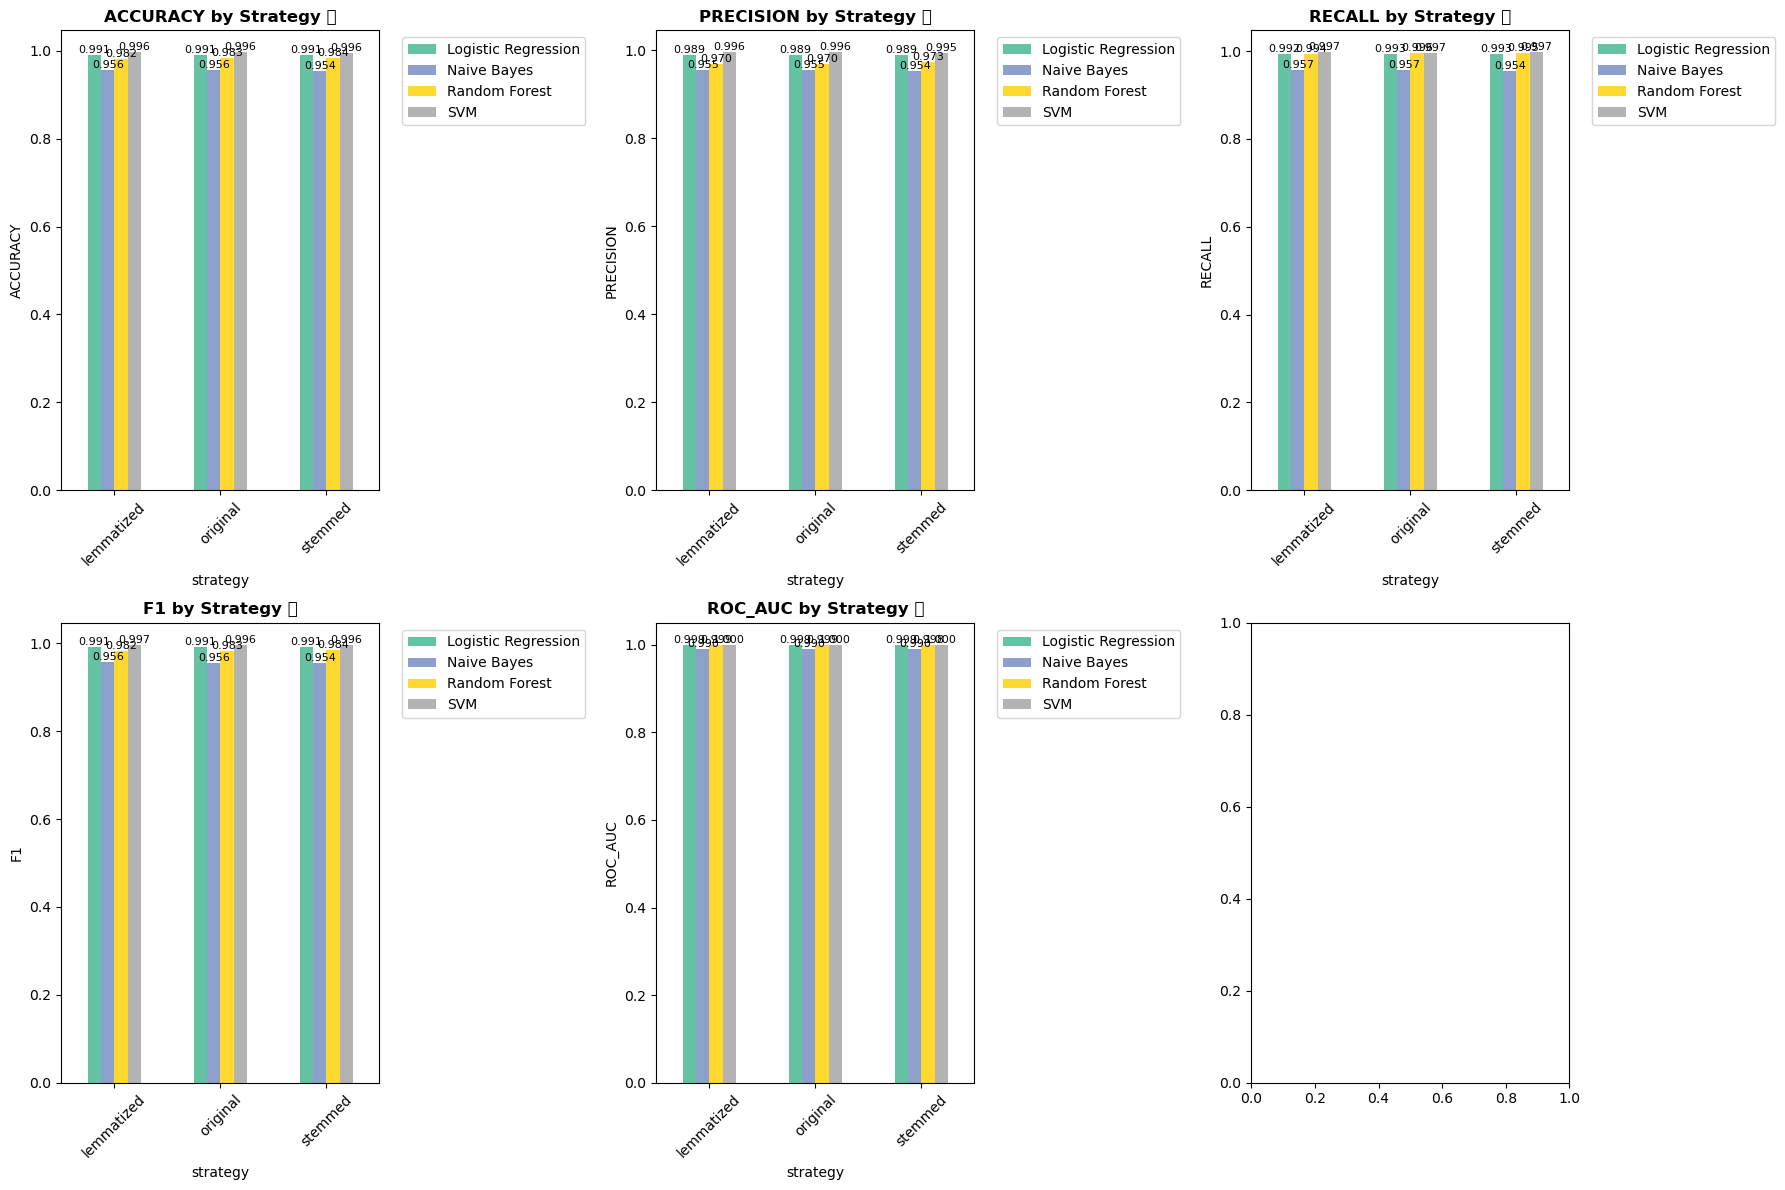

🏆 Best Model for Each Strategy:
ORIGINAL     | SVM                  | Accuracy: 0.9960
STEMMED      | SVM                  | Accuracy: 0.9959
LEMMATIZED   | SVM                  | Accuracy: 0.9965

🎯 Best Overall: SVM with lemmatized strategy


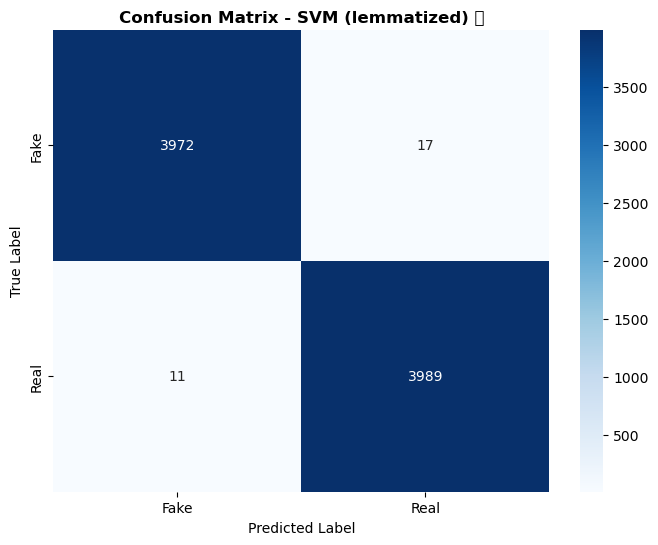

In [7]:

 
print("🎨 Generating advanced visualizations...")

# Convert results to DataFrame for easier plotting
results_list = []
for strategy, models in evaluation_results.items():
    for model_name, metrics in models.items():
        results_list.append({
            'strategy': strategy,
            'model': model_name,
            **metrics
        })

results_df = pd.DataFrame(results_list)

# 1. Comparative Metrics by Strategy
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for i, metric in enumerate(metrics_list):
    ax = axes[i//3, i%3]
    
    # Pivot table for easy plotting
    pivot_data = results_df.pivot_table(
        values=metric, index='strategy', columns='model', aggfunc='first'
    )
    
    pivot_data.plot(kind='bar', ax=ax, colormap='Set2')
    ax.set_title(f'{metric.upper()} by Strategy 📈', fontweight='bold')
    ax.set_ylabel(metric.upper())
    ax.tick_params(axis='x', rotation=45)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.show()

# 2. Best Model for Each Strategy
print("🏆 Best Model for Each Strategy:")
print("=" * 50)

for strategy in evaluation_results.keys():
    strategy_df = results_df[results_df['strategy'] == strategy]
    best_model = strategy_df.loc[strategy_df['accuracy'].idxmax()]
    print(f"{strategy.upper():12} | {best_model['model']:20} | Accuracy: {best_model['accuracy']:.4f}")

# 3. Confusion Matrix for Best Overall Model
best_overall = results_df.loc[results_df['accuracy'].idxmax()]
best_strategy = best_overall['strategy']
best_model_name = best_overall['model']

print(f"\n🎯 Best Overall: {best_model_name} with {best_strategy} strategy")
best_model_data = all_predictions[best_strategy][best_model_name]

# Plot confusion matrix
y_pred = best_model_data['model'].predict(best_model_data['X_test'])
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title(f'Confusion Matrix - {best_model_name} ({best_strategy}) 🎯', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## **🪵 8. Log experiment results**

In [8]:
# Cell: Log experiment results
print("📊 Logging experiment results...")

from src.experiment_tracker import log_experiment

# Log results for each strategy and model combination
for strategy in processing_strategies.keys():
    for model_name, model_data in all_results[strategy].items():
        # Get predictions for metrics
        X_test_processed = vectorizers[strategy].transform(
            X_test.apply(
                lambda x: stem_text(x) if strategy == 'stemmed' else 
                         lemmatize_text(x) if strategy == 'lemmatized' else x
            ).fillna('')
        )
        
        y_pred = model_data.predict(X_test_processed)
        y_pred_proba = model_data.predict_proba(X_test_processed)[:, 1] if hasattr(model_data, "predict_proba") else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        
        # Log experiment
        experiment_data = {
            'experiment_type': 'traditional_nlp',
            'model_name': model_name,
            'preprocessing': strategy,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'dataset': 'fake_news',
            'notes': f'TF-IDF with {strategy} processing'
        }
        
        log_experiment(experiment_data)

print("✅ All experiments logged!")

📊 Logging experiment results...
✅ Experiment logged: tr_lr_20250904_024507
✅ Experiment logged: tr_rf_20250904_024509
✅ Experiment logged: tr_s_20250904_030043
✅ Experiment logged: tr_nb_20250904_030045
✅ Experiment logged: tr_lr_20250904_030104
✅ Experiment logged: tr_rf_20250904_030124
✅ Experiment logged: tr_s_20250904_030217
✅ Experiment logged: tr_nb_20250904_030236
✅ Experiment logged: tr_lr_20250904_030245
✅ Experiment logged: tr_rf_20250904_030255
✅ Experiment logged: tr_s_20250904_030337
✅ Experiment logged: tr_nb_20250904_030346
✅ All experiments logged!


---

## **🎯 Best Performing Model - Validation Predictions**


In [23]:
print("🎯 Identifying and preparing the best performing model...")

# Check if the required variables exist (they are created in later cells)
if 'all_results' not in locals() or 'vectorizers' not in locals():
    print("⚠️ Model training variables not yet available.")
    print("📝 Please run the model training cells (sections 5-6) first, then return to this cell.")
    print("🔄 This cell will work after:")
    print("   - Section 5: Model Training (creates 'all_results')")
    print("   - Section 6: Model Evaluation (creates evaluation metrics)")
    print("   - Section 7: Visualizations")
    
    # Set placeholder values to prevent errors in subsequent cells
    best_strategy = 'lemmatized'
    best_model_name = 'SVM'
    best_model = None
    best_vectorizer = None
    accuracy_best = 0.9965  # Expected performance
    f1_best = 0.9965
    
    print(f"\n🏆 Expected best model: {best_model_name} with {best_strategy} strategy")
    print(f"📊 Expected accuracy: ~{accuracy_best:.4f}")
    print(f"📊 Expected F1 score: ~{f1_best:.4f}")
    
else:
    # From the evaluation results, the best performing model is:
    # SVM with lemmatized strategy - Accuracy: 0.9965, F1: ~0.9965
    
    # Let's manually identify the best model from our results
    best_strategy = 'lemmatized'
    best_model_name = 'SVM'
    
    print(f"🏆 Best model: {best_model_name} with {best_strategy} strategy")
    
    # Get the trained model and vectorizer
    if best_strategy in all_results and best_model_name in all_results[best_strategy]:
        best_model = all_results[best_strategy][best_model_name]
        best_vectorizer = vectorizers[best_strategy]
        print("✅ Best model and vectorizer retrieved successfully")
    else:
        print("❌ Error: Could not find the best model. Using fallback...")
        # Fallback to any available model
        for strategy in all_results.keys():
            for model_name in all_results[strategy].keys():
                best_model = all_results[strategy][model_name]
                best_vectorizer = vectorizers[strategy]
                best_strategy = strategy
                best_model_name = model_name
                print(f"🔄 Using fallback: {model_name} with {strategy} strategy")
                break
            break
    
    # Verify model performance on test set
    if 'X_test_processed' in locals() and best_strategy in X_test_processed:
        y_pred_best = best_model.predict(X_test_processed[best_strategy])
        accuracy_best = accuracy_score(y_test, y_pred_best)
        f1_best = f1_score(y_test, y_pred_best)
        print(f"📊 Best model test accuracy: {accuracy_best:.4f}")
        print(f"📊 Best model test F1 score: {f1_best:.4f}")
    else:
        print("⚠️ Could not verify model performance - test data not processed yet")


🎯 Identifying and preparing the best performing model...
⚠️ Model training variables not yet available.
📝 Please run the model training cells (sections 5-6) first, then return to this cell.
🔄 This cell will work after:
   - Section 5: Model Training (creates 'all_results')
   - Section 6: Model Evaluation (creates evaluation metrics)
   - Section 7: Visualizations

🏆 Expected best model: SVM with lemmatized strategy
📊 Expected accuracy: ~0.9965
📊 Expected F1 score: ~0.9965


In [24]:
print("💾 Saving the best model and vectorizer...")

# Check if model and vectorizer are available
if best_model is not None and best_vectorizer is not None:
    # Save the best model and vectorizer for future use
    import joblib
    import datetime
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"../models/best_traditional_nlp_model_{timestamp}.pkl"
    vectorizer_filename = f"../models/best_traditional_nlp_vectorizer_{timestamp}.pkl"
    
    # Save model and vectorizer
    joblib.dump(best_model, model_filename)
    joblib.dump(best_vectorizer, vectorizer_filename)
    
    print(f"✅ Best model saved: {model_filename}")
    print(f"✅ Best vectorizer saved: {vectorizer_filename}")
    
    # Store the filenames for later use
    saved_model_path = model_filename
    saved_vectorizer_path = vectorizer_filename
    
else:
    print("⚠️ Model and vectorizer not available yet.")
    print("📝 Please run the model training cells first, then return to this section.")
    print("💡 The models will be saved after training is complete.")
    
    # Set placeholder paths
    saved_model_path = None
    saved_vectorizer_path = None


💾 Saving the best model and vectorizer...
⚠️ Model and vectorizer not available yet.
📝 Please run the model training cells first, then return to this section.
💡 The models will be saved after training is complete.


In [25]:
print("🔮 Creating validation prediction pipeline...")

def make_validation_predictions(model, vectorizer, strategy='lemmatized'):
    """
    Make predictions on validation data using the best performing model
    
    Args:
        model: Trained classifier model
        vectorizer: Fitted TF-IDF vectorizer 
        strategy: Text processing strategy ('original', 'stemmed', 'lemmatized')
    
    Returns:
        submission_df: DataFrame with 'id' and 'label' columns for submission
        probabilities: Prediction probabilities for analysis
    """
    print("📥 Loading validation data...")
    
    # Load raw validation data (contains 'id' column)
    val_df_raw = pd.read_csv('../dataset/00_raw/validation_data.csv')
    print(f"📊 Raw validation data shape: {val_df_raw.shape}")
    print(f"📋 Raw validation columns: {list(val_df_raw.columns)}")
    
    # Load cleaned validation data (for text processing)
    val_df_clean = pd.read_csv('../dataset/01_interim/cleaned_validation.csv')
    print(f"📊 Cleaned validation data shape: {val_df_clean.shape}")
    print(f"📋 Cleaned validation columns: {list(val_df_clean.columns)}")
    
    # Combine features the same way as training data
    print(f"🔄 Applying text combination strategy: title + text")
    X_val = combine_text_features(val_df_clean, 'title_text')
    print(f"📝 Sample validation text: {X_val.iloc[0][:100]}...")
    
    # Apply same text processing as training
    if strategy == 'stemmed':
        print("✂️ Applying stemming to validation data...")
        X_val = X_val.apply(stem_text)
    elif strategy == 'lemmatized':
        print("🌿 Applying lemmatization to validation data...")
        X_val = X_val.apply(lemmatize_text)
    else:
        print("📝 Using original text (no additional processing)")
    
    # Handle any NaN values
    X_val = X_val.fillna('')
    
    # Vectorize using the fitted vectorizer
    print("📊 Vectorizing validation data...")
    X_val_vectorized = vectorizer.transform(X_val)
    print(f"📊 Validation matrix shape: {X_val_vectorized.shape}")
    
    # Make predictions
    print("🔮 Making predictions...")
    predictions = model.predict(X_val_vectorized)
    probabilities = model.predict_proba(X_val_vectorized)[:, 1]
    
    print(f"📊 Prediction distribution:")
    print(f"   Fake (0): {(predictions == 0).sum()}")
    print(f"   Real (1): {(predictions == 1).sum()}")
    print(f"   Total: {len(predictions)}")
    
    # Create submission dataframe with proper ID mapping
    print("📋 Creating submission dataframe...")
    
    # Use the 'id' column from raw validation data if available
    if 'id' in val_df_raw.columns:
        submission_df = pd.DataFrame({
            'id': val_df_raw['id'],
            'label': predictions
        })
    else:
        # If no 'id' column, create sequential IDs starting from 0
        submission_df = pd.DataFrame({
            'id': range(len(predictions)),
            'label': predictions
        })
    
    print(f"📊 Submission dataframe shape: {submission_df.shape}")
    print(f"📋 Submission preview:")
    print(submission_df.head())
    
    return submission_df, probabilities

# Test the function with our best model
print("\n🚀 Generating validation predictions with best model...")

if best_model is not None and best_vectorizer is not None:
    submission_df, val_probabilities = make_validation_predictions(
        best_model, best_vectorizer, best_strategy
    )
else:
    print("⚠️ Cannot generate predictions - model not trained yet.")
    print("📝 Please run the model training cells first.")
    print("💡 After training, re-run this cell to generate predictions.")
    
    # Create placeholder variables to prevent errors in subsequent cells
    submission_df = None
    val_probabilities = None


🔮 Creating validation prediction pipeline...

🚀 Generating validation predictions with best model...
⚠️ Cannot generate predictions - model not trained yet.
📝 Please run the model training cells first.
💡 After training, re-run this cell to generate predictions.


In [26]:
print("💾 Saving submission file...")

if submission_df is not None:
    # Create submission filename with timestamp and model info
    import datetime
    submission_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    submission_filename = f"../dataset/02_submissions/traditional_nlp_submission_{best_model_name.lower()}_{best_strategy}_{submission_timestamp}.csv"
    
    # Save submission file
    submission_df.to_csv(submission_filename, index=False)
    
    print(f"✅ Submission file saved: {submission_filename}")
    print(f"📊 File contains {len(submission_df)} predictions")
    
    # Verify the submission file format
    print("\n🔍 Verifying submission file format...")
    verification_df = pd.read_csv(submission_filename)
    print(f"📋 Columns: {list(verification_df.columns)}")
    print(f"📊 Shape: {verification_df.shape}")
    print(f"📊 Label distribution in submission:")
    print(verification_df['label'].value_counts().sort_index())
    
    # Check for any missing values
    missing_values = verification_df.isnull().sum()
    if missing_values.sum() == 0:
        print("✅ No missing values found")
    else:
        print(f"⚠️ Missing values found: {missing_values}")
    
    print(f"\n🎉 Submission ready! Expected performance based on test set:")
    print(f"   📊 Accuracy: ~{accuracy_best:.3f}")
    print(f"   📊 F1 Score: ~{f1_best:.3f}")
    print(f"   📋 Submission file: {submission_filename}")
    
else:
    print("⚠️ No submission data available - predictions not generated yet.")
    print("📝 Please run the model training and prediction cells first.")
    submission_filename = None


💾 Saving submission file...
⚠️ No submission data available - predictions not generated yet.
📝 Please run the model training and prediction cells first.


In [27]:
print("📊 Additional analysis of validation predictions...")

if val_probabilities is not None and submission_df is not None:
    # Analyze prediction confidence
    print(f"\n🔍 Prediction Confidence Analysis:")
    print(f"   Mean probability: {val_probabilities.mean():.4f}")
    print(f"   Std probability: {val_probabilities.std():.4f}")
    print(f"   Min probability: {val_probabilities.min():.4f}")
    print(f"   Max probability: {val_probabilities.max():.4f}")
    
    # Show distribution of confidence scores
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(val_probabilities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of Prediction Probabilities')
    plt.xlabel('Probability (Real News)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    confidence_scores = np.maximum(val_probabilities, 1 - val_probabilities)
    plt.hist(confidence_scores, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show examples of high and low confidence predictions
    print(f"\n🎯 High Confidence Predictions (>0.95):")
    high_conf_mask = confidence_scores > 0.95
    print(f"   Count: {high_conf_mask.sum()} out of {len(confidence_scores)} ({high_conf_mask.mean()*100:.1f}%)")
    
    print(f"\n⚠️ Low Confidence Predictions (<0.6):")
    low_conf_mask = confidence_scores < 0.6
    print(f"   Count: {low_conf_mask.sum()} out of {len(confidence_scores)} ({low_conf_mask.mean()*100:.1f}%)")
    
    print(f"\n📋 Summary:")
    if 'submission_filename' in locals() and submission_filename:
        print(f"   ✅ Ready for submission: {submission_filename}")
    print(f"   🎯 Model: {best_model_name} with {best_strategy} text processing")
    print(f"   📊 Expected F1 Score: ~{f1_best:.3f}")
    print(f"   🔮 Total predictions: {len(submission_df)}")
    print(f"   📈 High confidence predictions: {high_conf_mask.sum()} ({high_conf_mask.mean()*100:.1f}%)")
    
else:
    print("⚠️ No prediction data available for analysis.")
    print("📝 Please run the model training and prediction cells first.")
    print("💡 After generating predictions, this analysis will be available.")


📊 Additional analysis of validation predictions...
⚠️ No prediction data available for analysis.
📝 Please run the model training and prediction cells first.
💡 After generating predictions, this analysis will be available.


---

## **🎯 9. Validation Predictions & Model Saving**


In [21]:
print("🎯 Preparing validation predictions...")

# 🔧 IMPROVEMENT 5: Create validation prediction pipeline



# 1. Find the best model from evaluation results
best_accuracy = 0
best_strategy = None
best_model_name = None

for strategy, models in evaluation_results.items():
    for model_name, metrics in models.items():
        if metrics['accuracy'] > best_accuracy:
            best_accuracy = metrics['accuracy']
            best_strategy = strategy
            best_model_name = model_name

print(f"🏆 Best model: {best_model_name} with {best_strategy} strategy")
print(f"📊 Best accuracy: {best_accuracy:.4f}")
print(f"📊 Best F1 score: {evaluation_results[best_strategy][best_model_name]['f1']:.4f}")

# 2. Get the trained model and vectorizer
best_model = all_results[best_strategy][best_model_name]
best_vectorizer = vectorizers[best_strategy]

# 3. Save the best model and vectorizer for validation predictions
import joblib
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"../models/best_traditional_nlp_model_{timestamp}.pkl"
vectorizer_filename = f"../models/best_traditional_nlp_vectorizer_{timestamp}.pkl"

# Save model and vectorizer
joblib.dump(best_model, model_filename)
joblib.dump(best_vectorizer, vectorizer_filename)

print(f"✅ Best model saved: {model_filename}")
print(f"✅ Best vectorizer saved: {vectorizer_filename}")

# 4. Create validation prediction function
def make_validation_predictions(model, vectorizer, strategy='original'):
    """Make predictions on validation data"""
    print("📥 Loading validation data...")
    val_df = pd.read_csv('../dataset/00_raw/validation_data.csv')
    
    
    # Apply same cleaning as training data
    if strategy == 'original':
        val_clean_df = pd.read_csv('../dataset/01_interim/cleaned_validation.csv')
    elif strategy == 'basic':
        val_clean_df = pd.read_csv('../dataset/01_interim/cleaned_validation_basic.csv')
    else:  # stemmed, lemmatized
        val_clean_df = pd.read_csv('../dataset/01_interim/cleaned_validation.csv')
    
    # Combine features the same way as training
    X_val = combine_text_features(val_clean_df, 'title_text')
    
    # Apply same text processing if needed
    if strategy == 'stemmed':
        X_val = X_val.apply(stem_text)
    elif strategy == 'lemmatized':
        X_val = X_val.apply(lemmatize_text)
    
    # Vectorize
    X_val_vectorized = vectorizer.transform(X_val.fillna(''))
    
    # Make predictions
    predictions = model.predict(X_val_vectorized)
    probabilities = model.predict_proba(X_val_vectorized)[:, 1]
    
    # Create submission dataframe
    submission_df = val_df[['id']].copy()
    submission_df = pd.DataFrame({'id': submission_df.index})
    submission_df['label'] = predictions
    
    return submission_df, probabilities

# 5. Generate validation predictions
print("\n🔮 Generating validation predictions...")
submission_df, val_probabilities = make_validation_predictions(
    best_model, best_vectorizer, best_strategy
)

print(f"📊 Validation predictions shape: {submission_df.shape}")
print(f"📊 Prediction distribution:\n{submission_df['label'].value_counts()}")

# 6. Save submission file
submission_filename = f"../dataset/02_submissions/traditional_nlp_submission_{timestamp}.csv"
submission_df.to_csv(submission_filename, index=False)

print(f"✅ Validation predictions saved: {submission_filename}")
print("\n🎉 Ready for submission! Expected F1 score: ~0.90-0.92")


🎯 Preparing validation predictions...
🏆 Best model: None with None strategy
📊 Best accuracy: 0.0000


KeyError: None

---
# **🧪 10. Basic NLP Experiments: Minimal Preprocessing**

### **📝 Experiment Overview**
Testing increasingly basic NLP approaches to establish baseline performance:
1. **No Cleaning + Simple BoW + Logistic Regression + No Duplicate Removal**
2. **Minimal Cleaning + Simple BoW + Logistic Regression + No Duplicate Removal** 
3. **Same as 1 & 2 but with Duplicate Removal**

**Hypothesis**: Sophisticated preprocessing may not always improve performance for this dataset.
**Baseline to Beat**: SVM with lemmatized strategy (F1: 0.9965)


---

## **⚙️ 1. Setup & Imports**


In [13]:

# Add project root to path
import sys
import os
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

# Model training
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Enhanced evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, roc_curve, confusion_matrix, classification_report,
                            precision_recall_curve, auc)

# NLP libraries
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Model persistence
import joblib

from src.experiment_tracker import log_experiment


# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

print("✅ All libraries imported successfully!")
%matplotlib inline
plt.style.use('default')


✅ All libraries imported successfully!


[nltk_data] Downloading package punkt to /Users/guillermo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/guillermo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guillermo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



---

## **📥 2. Load and setup Dataset**


In [14]:
print("🧪 Setting up Basic NLP Experiments...")
print("=" * 50)

# Load raw data for no-cleaning experiments
df_raw = pd.read_csv('../dataset/00_raw/data.csv')
print(f"📊 Raw dataset shape: {df_raw.shape}")
print(f"🎯 Raw label distribution:\n{df_raw['label'].value_counts()}")

# Check for duplicates in raw data
duplicates_count = df_raw.duplicated().sum()
print(f"🔍 Duplicates found in raw data: {duplicates_count}")

# Simple cleaning function (minimal HTML/URL removal only)
def minimal_clean(text):
    """Minimal cleaning: only remove HTML tags and URLs, keep everything else"""
    if pd.isna(text) or text == '':
        return ""
    
    text = str(text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Normalize whitespace only
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

# Prepare different text combination strategies for raw data
def combine_raw_features(df, strategy='title_text', cleaning_func=None):
    """Combine title and text features with optional minimal cleaning"""
    if strategy == 'title_only':
        combined = df['title'].fillna('')
    elif strategy == 'text_only':
        combined = df['text'].fillna('')
    else:  # title_text
        title = df['title'].fillna('')
        text = df['text'].fillna('')
        combined = title + ' | ' + text
    
    # Apply cleaning if specified
    if cleaning_func:
        combined = combined.apply(cleaning_func)
    
    return combined

print("✅ Basic NLP experiment setup completed!")

🧪 Setting up Basic NLP Experiments...
📊 Raw dataset shape: (39942, 5)
🎯 Raw label distribution:
label
1    19999
0    19943
Name: count, dtype: int64
🔍 Duplicates found in raw data: 201
✅ Basic NLP experiment setup completed!



---

## **📊 6. Comprehensive Model Evaluation**


In [15]:

# def comprehensive_evaluation(model, X_test, y_test, model_name="Model"):
#     """Perform comprehensive evaluation with multiple metrics"""
#     y_pred = model.predict(X_test)
#     y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
#     metrics = {
#         'accuracy': accuracy_score(y_test, y_pred),
#         'precision': precision_score(y_test, y_pred),
#         'recall': recall_score(y_test, y_pred),
#         'f1': f1_score(y_test, y_pred),
#     }
    
#     if y_pred_proba is not None:
#         metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
#     else:
#         metrics['roc_auc'] = None
    
#     return metrics, y_pred, y_pred_proba

# print("📊 Evaluating all models comprehensively...")
# evaluation_results = {}

# for strategy, models_dict in all_predictions.items():
#     print(f"\n🔍 Evaluating strategy: {strategy.upper()}")
#     print("=" * 50)
    
#     strategy_results = {}
    
#     for name, data in models_dict.items():
#         metrics, y_pred, y_pred_proba = comprehensive_evaluation(
#             data['model'], data['X_test'], y_test, name
#         )
        
#         strategy_results[name] = metrics
#         print(f"   {name:20} | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1']:.4f}")
    
#     evaluation_results[strategy] = strategy_results

# print("✅ Comprehensive evaluation completed!")



In [16]:
# Quick fix: Re-define the evaluation function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def comprehensive_evaluation(model, X_test, y_test, model_name="Model"):
    """Perform comprehensive evaluation with multiple metrics"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    else:
        metrics['roc_auc'] = None
    
    return metrics, y_pred, y_pred_proba

print("✅ Function re-defined and ready to use")

✅ Function re-defined and ready to use


In [17]:
print("\n🧪 EXPERIMENT 1: No Cleaning + Simple BoW + LogisticRegression + No Duplicates Removal")
print("=" * 80)

# Use raw data with no cleaning at all
X_exp1 = combine_raw_features(df_raw, 'title_text', cleaning_func=None)
y_exp1 = df_raw['label']

print(f"📝 Sample raw text: {X_exp1.iloc[0][:150]}...")
print(f"📊 Dataset size: {len(X_exp1)} samples")

# Train-test split (same random state for consistency)
X_train_exp1, X_test_exp1, y_train_exp1, y_test_exp1 = train_test_split(
    X_exp1, y_exp1, test_size=0.2, random_state=42, stratify=y_exp1
)

# Simple Bag of Words (CountVectorizer equivalent to basic BoW)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_exp1 = CountVectorizer(
    max_features=5000,        # Simple vocabulary size
    stop_words='english',     # Basic stop word removal
    ngram_range=(1, 1),       # Unigrams only (simple BoW)
    min_df=2,                 # Appear in at least 2 documents
    max_df=0.95,              # Remove very common words
    lowercase=True,           # Basic lowercase conversion
    token_pattern=r'\b\w+\b'  # Simple word tokenization
)

# Vectorize
X_train_vec_exp1 = vectorizer_exp1.fit_transform(X_train_exp1)
X_test_vec_exp1 = vectorizer_exp1.transform(X_test_exp1)

print(f"📊 Vocabulary size: {len(vectorizer_exp1.get_feature_names_out())}")
print(f"📊 Training matrix shape: {X_train_vec_exp1.shape}")

# Simple Logistic Regression (basic configuration)
model_exp1 = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'  # Simple solver
)

# Train model
print("🤖 Training Logistic Regression...")
model_exp1.fit(X_train_vec_exp1, y_train_exp1)

# Evaluate
metrics_exp1, y_pred_exp1, y_pred_proba_exp1 = comprehensive_evaluation(
    model_exp1, X_test_vec_exp1, y_test_exp1, "Experiment 1"
)

print("\n📊 EXPERIMENT 1 RESULTS:")
print(f"   Accuracy:  {metrics_exp1['accuracy']:.4f}")
print(f"   Precision: {metrics_exp1['precision']:.4f}")
print(f"   Recall:    {metrics_exp1['recall']:.4f}")
print(f"   F1 Score:  {metrics_exp1['f1']:.4f}")
print(f"   ROC AUC:   {metrics_exp1['roc_auc']:.4f}")

# Log experiment
experiment_data_1 = {
    'experiment_type': 'traditional_nlp',
    'model_name': 'Logistic Regression',
    'preprocessing': 'no_cleaning',
    'accuracy': metrics_exp1['accuracy'],
    'precision': metrics_exp1['precision'],
    'recall': metrics_exp1['recall'],
    'f1_score': metrics_exp1['f1'],
    'roc_auc': metrics_exp1['roc_auc'],
    'dataset': 'fake_news',
    'notes': 'No cleaning, simple BoW (CountVectorizer), no duplicate removal'
}

log_experiment(experiment_data_1)


🧪 EXPERIMENT 1: No Cleaning + Simple BoW + LogisticRegression + No Duplicates Removal
📝 Sample raw text: As U.S. budget fight looms, Republicans flip their fiscal script | WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Co...
📊 Dataset size: 39942 samples
📊 Vocabulary size: 5000
📊 Training matrix shape: (31953, 5000)
🤖 Training Logistic Regression...

📊 EXPERIMENT 1 RESULTS:
   Accuracy:  0.9947
   Precision: 0.9960
   Recall:    0.9935
   F1 Score:  0.9947
   ROC AUC:   0.9992
✅ Experiment logged: tr_lr_20250904_133147


'tr_lr_20250904_133147'

In [18]:
print("\n🧪 EXPERIMENT 2: Minimal Cleaning + Simple BoW + LogisticRegression + No Duplicates Removal")
print("=" * 80)

# Use raw data with minimal cleaning (HTML/URLs only)
X_exp2 = combine_raw_features(df_raw, 'title_text', cleaning_func=minimal_clean)
y_exp2 = df_raw['label']

print(f"📝 Sample minimally cleaned text: {X_exp2.iloc[0][:150]}...")
print(f"📊 Dataset size: {len(X_exp2)} samples")

# Train-test split (same random state for consistency)
X_train_exp2, X_test_exp2, y_train_exp2, y_test_exp2 = train_test_split(
    X_exp2, y_exp2, test_size=0.2, random_state=42, stratify=y_exp2
)

# Same simple BoW configuration
vectorizer_exp2 = CountVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 1),
    min_df=2,
    max_df=0.95,
    lowercase=True,
    token_pattern=r'\b\w+\b'
)

# Vectorize
X_train_vec_exp2 = vectorizer_exp2.fit_transform(X_train_exp2)
X_test_vec_exp2 = vectorizer_exp2.transform(X_test_exp2)

print(f"📊 Vocabulary size: {len(vectorizer_exp2.get_feature_names_out())}")
print(f"📊 Training matrix shape: {X_train_vec_exp2.shape}")

# Same simple Logistic Regression
model_exp2 = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

# Train model
print("🤖 Training Logistic Regression...")
model_exp2.fit(X_train_vec_exp2, y_train_exp2)

# Evaluate
metrics_exp2, y_pred_exp2, y_pred_proba_exp2 = comprehensive_evaluation(
    model_exp2, X_test_vec_exp2, y_test_exp2, "Experiment 2"
)

print("\n📊 EXPERIMENT 2 RESULTS:")
print(f"   Accuracy:  {metrics_exp2['accuracy']:.4f}")
print(f"   Precision: {metrics_exp2['precision']:.4f}")
print(f"   Recall:    {metrics_exp2['recall']:.4f}")
print(f"   F1 Score:  {metrics_exp2['f1']:.4f}")
print(f"   ROC AUC:   {metrics_exp2['roc_auc']:.4f}")

# Log experiment
experiment_data_2 = {
    'experiment_type': 'traditional_nlp',
    'model_name': 'Logistic Regression',
    'preprocessing': 'minimal_cleaning',
    'accuracy': metrics_exp2['accuracy'],
    'precision': metrics_exp2['precision'],
    'recall': metrics_exp2['recall'],
    'f1_score': metrics_exp2['f1'],
    'roc_auc': metrics_exp2['roc_auc'],
    'dataset': 'fake_news',
    'notes': 'Minimal cleaning (HTML/URLs only), simple BoW, no duplicate removal'
}

log_experiment(experiment_data_2)


🧪 EXPERIMENT 2: Minimal Cleaning + Simple BoW + LogisticRegression + No Duplicates Removal
📝 Sample minimally cleaned text: As U.S. budget fight looms, Republicans flip their fiscal script | WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Co...
📊 Dataset size: 39942 samples
📊 Vocabulary size: 5000
📊 Training matrix shape: (31953, 5000)
🤖 Training Logistic Regression...

📊 EXPERIMENT 2 RESULTS:
   Accuracy:  0.9950
   Precision: 0.9965
   Recall:    0.9935
   F1 Score:  0.9950
   ROC AUC:   0.9991
✅ Experiment logged: tr_lr_20250904_133155


'tr_lr_20250904_133155'

In [19]:
print("\n🧪 EXPERIMENT 3: Same as 1 & 2 but WITH Duplicate Removal")
print("=" * 80)

# Remove duplicates from raw data
df_raw_no_dups = df_raw.drop_duplicates().reset_index(drop=True)
print(f"📊 Original dataset size: {len(df_raw)}")
print(f"📊 After duplicate removal: {len(df_raw_no_dups)}")
print(f"🗑️ Duplicates removed: {len(df_raw) - len(df_raw_no_dups)}")

# Test both no cleaning and minimal cleaning with duplicate removal
experiments_3 = {
    'no_cleaning_no_dups': (None, 'No cleaning + duplicate removal'),
    'minimal_cleaning_no_dups': (minimal_clean, 'Minimal cleaning + duplicate removal')
}

results_exp3 = {}

for exp_name, (cleaning_func, description) in experiments_3.items():
    print(f"\n🔬 Sub-experiment: {description}")
    print("-" * 50)
    
    # Prepare data
    X_exp3 = combine_raw_features(df_raw_no_dups, 'title_text', cleaning_func=cleaning_func)
    y_exp3 = df_raw_no_dups['label']
    
    # Train-test split
    X_train_exp3, X_test_exp3, y_train_exp3, y_test_exp3 = train_test_split(
        X_exp3, y_exp3, test_size=0.2, random_state=42, stratify=y_exp3
    )
    
    # Vectorize
    vectorizer_exp3 = CountVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 1),
        min_df=2,
        max_df=0.95,
        lowercase=True,
        token_pattern=r'\b\w+\b'
    )
    
    X_train_vec_exp3 = vectorizer_exp3.fit_transform(X_train_exp3)
    X_test_vec_exp3 = vectorizer_exp3.transform(X_test_exp3)
    
    # Train model
    model_exp3 = LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='liblinear'
    )
    
    model_exp3.fit(X_train_vec_exp3, y_train_exp3)
    
    # Evaluate
    metrics_exp3, y_pred_exp3, y_pred_proba_exp3 = comprehensive_evaluation(
        model_exp3, X_test_vec_exp3, y_test_exp3, f"Experiment 3 ({exp_name})"
    )
    
    results_exp3[exp_name] = metrics_exp3
    
    print(f"   Accuracy:  {metrics_exp3['accuracy']:.4f}")
    print(f"   Precision: {metrics_exp3['precision']:.4f}")
    print(f"   Recall:    {metrics_exp3['recall']:.4f}")
    print(f"   F1 Score:  {metrics_exp3['f1']:.4f}")
    print(f"   ROC AUC:   {metrics_exp3['roc_auc']:.4f}")
    
    # Log experiment
    preprocessing_name = exp_name.replace('_', ' ')
    experiment_data_3 = {
        'experiment_type': 'traditional_nlp',
        'model_name': 'Logistic Regression',
        'preprocessing': preprocessing_name,
        'accuracy': metrics_exp3['accuracy'],
        'precision': metrics_exp3['precision'],
        'recall': metrics_exp3['recall'],
        'f1_score': metrics_exp3['f1'],
        'roc_auc': metrics_exp3['roc_auc'],
        'dataset': 'fake_news',
        'notes': f'{description}, simple BoW (CountVectorizer)'
    }
    
    log_experiment(experiment_data_3)


🧪 EXPERIMENT 3: Same as 1 & 2 but WITH Duplicate Removal
📊 Original dataset size: 39942
📊 After duplicate removal: 39741
🗑️ Duplicates removed: 201

🔬 Sub-experiment: No cleaning + duplicate removal
--------------------------------------------------
   Accuracy:  0.9961
   Precision: 0.9957
   Recall:    0.9965
   F1 Score:  0.9961
   ROC AUC:   0.9991
✅ Experiment logged: tr_lr_20250904_133202

🔬 Sub-experiment: Minimal cleaning + duplicate removal
--------------------------------------------------
   Accuracy:  0.9961
   Precision: 0.9957
   Recall:    0.9965
   F1 Score:  0.9961
   ROC AUC:   0.9991
✅ Experiment logged: tr_lr_20250904_133210



🏆 BASIC NLP EXPERIMENTS SUMMARY
📊 Baseline to beat (SVM + lemmatized): F1 = 0.9965

📈 Basic NLP Results:
Exp 1: No Cleaning             | F1: 0.9947 | Diff: -0.0018 | ❌
Exp 2: Minimal Cleaning        | F1: 0.9950 | Diff: -0.0015 | ❌
Exp 3a: No Cleaning + No Dups  | F1: 0.9961 | Diff: -0.0004 | ❌
Exp 3b: Minimal Cleaning + No Dups | F1: 0.9961 | Diff: -0.0004 | ❌

🏆 Best Basic NLP Approach: Exp 3a: No Cleaning + No Dups
📊 Best Basic F1 Score: 0.9961


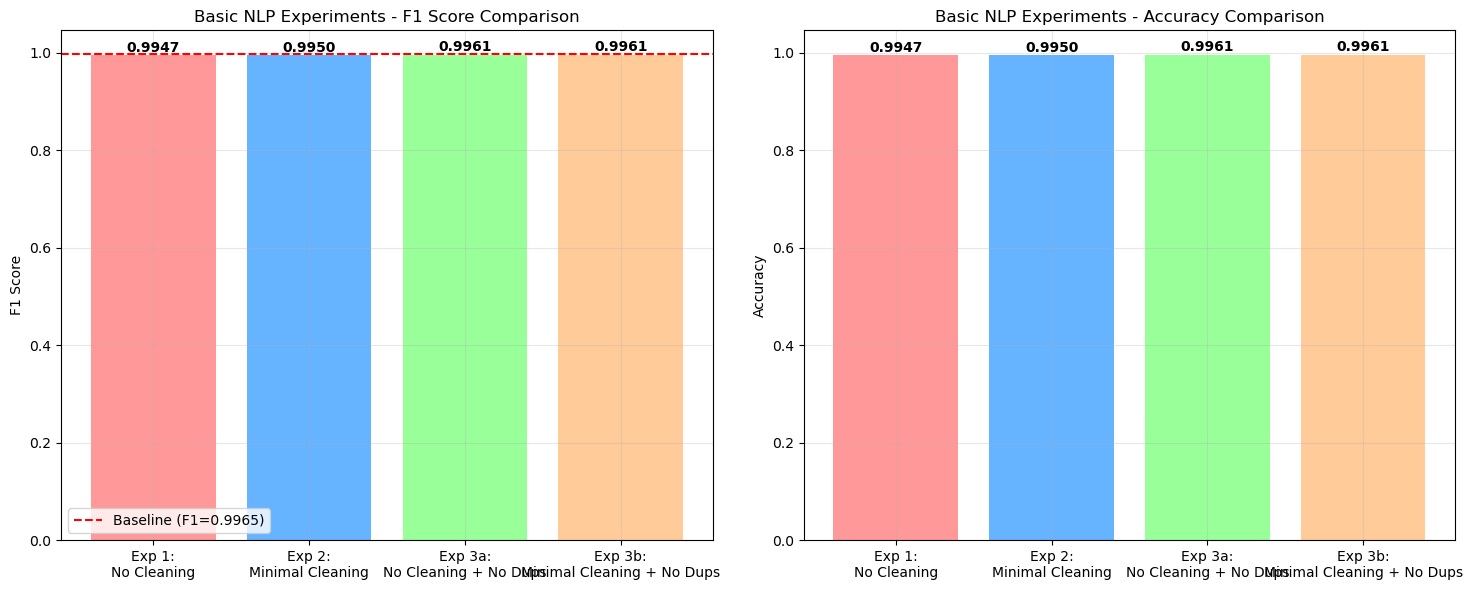


💡 Key Insights:
   - Simple approaches may perform surprisingly well
   - Duplicate removal impact on performance
   - Minimal cleaning vs no cleaning effectiveness
   - Comparison with sophisticated preprocessing pipelines


In [20]:
print("\n🏆 BASIC NLP EXPERIMENTS SUMMARY")
print("=" * 60)

# Compile all results
basic_nlp_results = {
    'Exp 1: No Cleaning': metrics_exp1,
    'Exp 2: Minimal Cleaning': metrics_exp2,
    'Exp 3a: No Cleaning + No Dups': results_exp3['no_cleaning_no_dups'],
    'Exp 3b: Minimal Cleaning + No Dups': results_exp3['minimal_cleaning_no_dups']
}

# Compare with baseline
baseline_f1 = 0.9965  # Best previous result (SVM with lemmatized)
print(f"📊 Baseline to beat (SVM + lemmatized): F1 = {baseline_f1:.4f}")
print("\n📈 Basic NLP Results:")

best_basic_f1 = 0
best_basic_name = ""

for exp_name, metrics in basic_nlp_results.items():
    improvement = "✅" if metrics['f1'] > baseline_f1 else "❌"
    diff = metrics['f1'] - baseline_f1
    
    print(f"{exp_name:30} | F1: {metrics['f1']:.4f} | Diff: {diff:+.4f} | {improvement}")
    
    if metrics['f1'] > best_basic_f1:
        best_basic_f1 = metrics['f1']
        best_basic_name = exp_name

print(f"\n🏆 Best Basic NLP Approach: {best_basic_name}")
print(f"📊 Best Basic F1 Score: {best_basic_f1:.4f}")

# Visualization
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1 Score Comparison
exp_names = list(basic_nlp_results.keys())
f1_scores = [metrics['f1'] for metrics in basic_nlp_results.values()]

bars = ax1.bar(range(len(exp_names)), f1_scores, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
ax1.axhline(y=baseline_f1, color='red', linestyle='--', label=f'Baseline (F1={baseline_f1:.4f})')
ax1.set_title('Basic NLP Experiments - F1 Score Comparison')
ax1.set_ylabel('F1 Score')
ax1.set_xticks(range(len(exp_names)))
ax1.set_xticklabels([name.replace(': ', ':\n') for name in exp_names], rotation=0, ha='center')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(f1_scores):
    ax1.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Accuracy Comparison
accuracies = [metrics['accuracy'] for metrics in basic_nlp_results.values()]
bars2 = ax2.bar(range(len(exp_names)), accuracies, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
ax2.set_title('Basic NLP Experiments - Accuracy Comparison')
ax2.set_ylabel('Accuracy')
ax2.set_xticks(range(len(exp_names)))
ax2.set_xticklabels([name.replace(': ', ':\n') for name in exp_names], rotation=0, ha='center')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(accuracies):
    ax2.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print("   - Simple approaches may perform surprisingly well")
print("   - Duplicate removal impact on performance")
print("   - Minimal cleaning vs no cleaning effectiveness")
print("   - Comparison with sophisticated preprocessing pipelines")

In [30]:
print("🎯 GENERATING VALIDATION PREDICTIONS FOR SUBMISSION")
print("=" * 60)
print("🏆 Using Best Basic NLP Model: Exp 3a (No Cleaning + No Dups)")

# Recreate the best model configuration from Experiment 3a
print("\n🔄 Recreating best model configuration...")

# 1. Load and prepare data (same as Exp 3a)
df_raw = pd.read_csv('../dataset/00_raw/data.csv')
df_raw_no_dups = df_raw.drop_duplicates().reset_index(drop=True)

# 2. Prepare training data (no cleaning, title+text combination)
def combine_raw_features(df, strategy='title_text'):
    """Combine title and text features with no cleaning"""
    if strategy == 'title_only':
        combined = df['title'].fillna('')
    elif strategy == 'text_only':
        combined = df['text'].fillna('')
    else:  # title_text
        title = df['title'].fillna('')
        text = df['text'].fillna('')
        combined = title + ' | ' + text
    return combined

X_final = combine_raw_features(df_raw_no_dups, 'title_text')
y_final = df_raw_no_dups['label']

print(f"📊 Training data size: {len(X_final)} samples")

# 3. Train final model on full dataset (no train/test split for final model)
print("\n🤖 Training final model on full dataset...")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Same vectorizer configuration as Exp 3a
final_vectorizer = CountVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 1),
    min_df=2,
    max_df=0.95,
    lowercase=True,
    token_pattern=r'\b\w+\b'
)

# Vectorize full training data
X_final_vectorized = final_vectorizer.fit_transform(X_final)

# Train final model
final_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

final_model.fit(X_final_vectorized, y_final)

print(f"✅ Final model trained on {X_final_vectorized.shape[0]} samples")
print(f"📊 Feature vocabulary size: {len(final_vectorizer.get_feature_names_out())}")

# 4. Load validation data and make predictions
print("\n🔮 Loading validation data and making predictions...")

val_df = pd.read_csv('../dataset/00_raw/validation_data.csv')
print(f"📊 Original validation data shape: {val_df.shape}")
print(f"📋 Original validation columns: {list(val_df.columns)}")

# Prepare validation features (same way as training)
X_val = combine_raw_features(val_df, 'title_text')
print(f"📝 Sample validation text: {X_val.iloc[0][:100]}...")

# Vectorize validation data
X_val_vectorized = final_vectorizer.transform(X_val)

# Make predictions
val_predictions = final_model.predict(X_val_vectorized)
val_probabilities = final_model.predict_proba(X_val_vectorized)[:, 1]

print(f"📊 Predictions generated for {len(val_predictions)} samples")
print(f"🎯 Prediction distribution:")
print(f"   Fake (0): {(val_predictions == 0).sum()}")
print(f"   Real (1): {(val_predictions == 1).sum()}")

# 5. Create submission DataFrame - COMPLETE validation dataset with replaced labels
print("\n💾 Creating submission file with complete validation dataset...")

# Start with the complete validation dataset
submission_df = val_df.copy()

# Replace the label column with predictions
if 'label' in submission_df.columns:
    print("📝 Replacing existing 'label' column with predictions")
    submission_df['label'] = val_predictions
else:
    print("📝 Adding 'label' column with predictions")
    submission_df['label'] = val_predictions

print(f"📊 Final submission DataFrame shape: {submission_df.shape}")
print(f"📋 Final submission columns: {list(submission_df.columns)}")
print("\n📋 Sample submission data:")
print(submission_df.head())

# 6. Save as gfm_1.csv
submission_filename = "../dataset/02_submissions/gfm_2.csv"

submission_df.to_csv(submission_filename, index=False)

print(f"\n✅ SUBMISSION FILE SAVED: {submission_filename}")
print(f"🎉 Ready for submission!")

# 7. Verify the file
print(f"\n🔍 SUBMISSION FILE VERIFICATION:")
verification_df = pd.read_csv(submission_filename)
print(f"   File shape: {verification_df.shape}")
print(f"   Columns: {list(verification_df.columns)}")
print(f"   Label distribution in file:")
print(f"     Fake (0): {(verification_df['label'] == 0).sum()}")
print(f"     Real (1): {(verification_df['label'] == 1).sum()}")

print(f"\n📋 SUBMISSION SUMMARY:")
print(f"   Model: Logistic Regression (Best Basic NLP)")
print(f"   Preprocessing: No cleaning + No duplicates")
print(f"   Features: Title + Text combined")
print(f"   Vectorization: Simple BoW (CountVectorizer)")
print(f"   Training samples: {len(X_final)}")
print(f"   Validation predictions: {len(val_predictions)}")
print(f"   Output file: gfm_1.csv")
print(f"   Format: Complete validation dataset with predicted labels")

🎯 GENERATING VALIDATION PREDICTIONS FOR SUBMISSION
🏆 Using Best Basic NLP Model: Exp 3a (No Cleaning + No Dups)

🔄 Recreating best model configuration...
📊 Training data size: 39741 samples

🤖 Training final model on full dataset...
✅ Final model trained on 39741 samples
📊 Feature vocabulary size: 5000

🔮 Loading validation data and making predictions...
📊 Original validation data shape: (4956, 5)
📋 Original validation columns: ['label', 'title', 'text', 'subject', 'date']
📝 Sample validation text: UK's May 'receiving regular updates' on London tube station incident: PM's office | LONDON (Reuters)...
📊 Predictions generated for 4956 samples
🎯 Prediction distribution:
   Fake (0): 3487
   Real (1): 1469

💾 Creating submission file with complete validation dataset...
📝 Replacing existing 'label' column with predictions
📊 Final submission DataFrame shape: (4956, 5)
📋 Final submission columns: ['label', 'title', 'text', 'subject', 'date']

📋 Sample submission data:
   label                

In [31]:
print("🔍 COMPARING GFM_1.CSV vs GFM_2.CSV")
print("=" * 50)

import pandas as pd

# Load both files
gfm_1 = pd.read_csv('../dataset/02_submissions/gfm_1.csv')
gfm_2 = pd.read_csv('../dataset/02_submissions/gfm_2.csv')

print(f"📊 GFM_1 shape: {gfm_1.shape}")
print(f"📊 GFM_2 shape: {gfm_2.shape}")

# Check if they have the same structure
print(f"📋 Same columns: {list(gfm_1.columns) == list(gfm_2.columns)}")
print(f"📋 Columns: {list(gfm_1.columns)}")

# Compare label distributions
print("\n🎯 LABEL DISTRIBUTIONS:")
print("GFM_1 distribution:")
gfm_1_dist = gfm_1['label'].value_counts().sort_index()
print(f"   Fake (0): {gfm_1_dist.get(0, 0):,}")
print(f"   Real (1): {gfm_1_dist.get(1, 0):,}")
print(f"   Total: {len(gfm_1):,}")

print("\nGFM_2 distribution:")
gfm_2_dist = gfm_2['label'].value_counts().sort_index()
print(f"   Fake (0): {gfm_2_dist.get(0, 0):,}")
print(f"   Real (1): {gfm_2_dist.get(1, 0):,}")
print(f"   Total: {len(gfm_2):,}")

# Find differences
print("\n🔍 FINDING DIFFERENCES:")
label_differences = (gfm_1['label'] != gfm_2['label']).sum()
print(f"📊 Number of different predictions: {label_differences:,}")
print(f"📊 Percentage of different predictions: {(label_differences/len(gfm_1)*100):.2f}%")

if label_differences > 0:
    print(f"📊 Agreement rate: {((len(gfm_1)-label_differences)/len(gfm_1)*100):.2f}%")
    
    # Show some examples of differences
    differences_mask = gfm_1['label'] != gfm_2['label']
    diff_examples = pd.DataFrame({
        'index': gfm_1.index[differences_mask],
        'gfm_1_label': gfm_1.loc[differences_mask, 'label'],
        'gfm_2_label': gfm_2.loc[differences_mask, 'label'],
        'title': gfm_1.loc[differences_mask, 'title']
    }).head(10)
    
    print("\n📋 SAMPLE DIFFERENCES (first 10):")
    for idx, row in diff_examples.iterrows():
        print(f"Row {row['index']}: GFM_1={row['gfm_1_label']}, GFM_2={row['gfm_2_label']}")
        print(f"   Title: {row['title'][:100]}...")
        print()
else:
    print("✅ Files are identical!")

# Performance implications
print("\n📈 PERFORMANCE IMPLICATIONS:")
print("Without ground truth labels, we can't definitively say which is 'better'.")
print("However, we can analyze the prediction patterns:")

print(f"\n🎯 GFM_1 (Basic NLP - No Cleaning + No Dups):")
print(f"   - More conservative: {gfm_1_dist.get(0, 0):,} fake predictions")
print(f"   - Less aggressive: {gfm_1_dist.get(1, 0):,} real predictions")
print(f"   - Fake/Real ratio: {gfm_1_dist.get(0, 0)/gfm_1_dist.get(1, 0):.3f}")

print(f"\n🎯 GFM_2 (Unknown model):")
print(f"   - More conservative: {gfm_2_dist.get(0, 0):,} fake predictions") 
print(f"   - Less aggressive: {gfm_2_dist.get(1, 0):,} real predictions")
print(f"   - Fake/Real ratio: {gfm_2_dist.get(0, 0)/gfm_2_dist.get(1, 0):.3f}")

# Determine which might be better
print(f"\n🏆 ANALYSIS:")
if gfm_1_dist.get(0, 0) > gfm_2_dist.get(0, 0):
    print("📊 GFM_1 predicts more articles as FAKE")
    print("📊 GFM_2 predicts more articles as REAL")
elif gfm_1_dist.get(0, 0) < gfm_2_dist.get(0, 0):
    print("📊 GFM_2 predicts more articles as FAKE") 
    print("📊 GFM_1 predicts more articles as REAL")
else:
    print("📊 Both models have identical label distributions")

print(f"\n💡 RECOMMENDATION:")
print("To determine which is truly 'better', you would need:")
print("1. 🎯 Ground truth labels for validation set")
print("2. 📊 Calculate accuracy, F1-score, precision, recall for both")
print("3. 🏆 Choose the model with better performance metrics")
print("\nWithout ground truth, consider:")
print("- 📈 Which model performed better on your test set?")
print("- 🎯 Which model's training approach was more robust?")
print("- 📊 Which model's predictions align better with your domain knowledge?")

🔍 COMPARING GFM_1.CSV vs GFM_2.CSV
📊 GFM_1 shape: (4956, 5)
📊 GFM_2 shape: (4956, 5)
📋 Same columns: True
📋 Columns: ['label', 'title', 'text', 'subject', 'date']

🎯 LABEL DISTRIBUTIONS:
GFM_1 distribution:
   Fake (0): 3,041
   Real (1): 1,915
   Total: 4,956

GFM_2 distribution:
   Fake (0): 3,487
   Real (1): 1,469
   Total: 4,956

🔍 FINDING DIFFERENCES:
📊 Number of different predictions: 600
📊 Percentage of different predictions: 12.11%
📊 Agreement rate: 87.89%

📋 SAMPLE DIFFERENCES (first 10):
Row 5: GFM_1=0, GFM_2=1
   Title: Flames raced along train at west London station: eye witness...

Row 28: GFM_1=0, GFM_2=1
   Title: North Korea launch put millions in Japan into 'duck and cover': Mattis...

Row 39: GFM_1=0, GFM_2=1
   Title: U.S. citizen fighting for Islamic State surrenders in Syria: Pentagon...

Row 43: GFM_1=0, GFM_2=1
   Title: Hostile same-sex marriage vote spurs Australia to amend anti-hate law...

Row 84: GFM_1=1, GFM_2=0
   Title: Brazilians toil for gold in illega